## We are here to explore the most recent trends for Airbnb accommodation in different cities. Ready, let's go!
Thanks to Airbnb Open data source: http://insideairbnb.com/get-the-data.html

[Data exploratory Questions]
1.	How does the average availability of Airbnb homes vary over time in each city? Is there a clear seasonal pattern for the average nightly rate on Airbnb in the chosen city? Is there a clear weekly pattern?
2.	Which neighborhood is the most expensive? Which property type is most common? 
3.	How does the trends compare between cities? Boston and Seattle?

[Model prediction] 
4.	Can we predict the listing price? We know that price quite depends on the location, but many other factors may help predict the listing price such as room type, property type, size, #beds, any correlation between # of comments and price? E.g. Multiple regression analysis can be done in Python to put these variables together to predict the listing price of a property？

In [103]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
#import sys

# Import plotting modules
import matplotlib.pyplot as plt
import matplotlib.dates as plotdates
import matplotlib.ticker as ticker
import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# import libraries for price prediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
#from lightgbm import LGBMRegressor

# import libraries for NLP processing - optional
from sklearn.feature_extraction import text 
import nltk
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, bigrams, FreqDist, ne_chunk
import detectEnglish

In [110]:
# define city and read in dataset
city = 'seattle'
calendar = pd.read_csv( city + '/calendar.csv.gz')
listing = pd.read_csv(city + '/listings.csv.gz')
review =pd.read_csv(city + '/reviews.csv.gz')

In [111]:
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the ' + city+ ' calendar data.')
print('We have', listing.id.nunique(), 'listings in the ' + city+ '  listing data.')
print('We have', review.shape[0], 'reviews for', review.listing_id.nunique(),'listings in the ' + city+ ' review data')

We have 374 days and 9067 unique listings in the seattle calendar data.
We have 9067 listings in the seattle  listing data.
We have 436392 reviews for 7844 listings in the seattle review data


In [112]:
#listing.head()
#review.head()
#calendar.head()
#listings_seattle.iloc[1000:1200,]
#calendar.info()
#calendar.dtypes

In [113]:
print("Listing dataset has %2d records and %2d columns" %(listing.shape[0],listing.shape[1]))
print("Calendar dataset has %2d records and %2d columns" %(calendar.shape[0],calendar.shape[1]))
print("Review dataset has %2d records and %2d columns" %(review.shape[0],review.shape[1]))

Listing dataset has 9067 records and 106 columns
Calendar dataset has 3309455 records and  7 columns
Review dataset has 436392 records and  6 columns


### Prepare Calendar Data Set to Answer Question 1

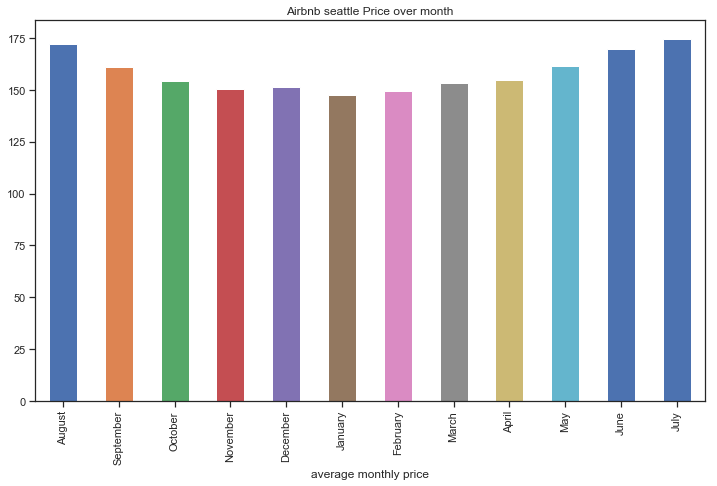

In [114]:
#changing data type for price and date
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)

calendar['date'] = pd.to_datetime(calendar['date'])
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()
mean_of_month.plot(kind = 'bar' , figsize = (12,7))
plt.title('Airbnb '+ city + ' Price over month')
plt.xlabel('average monthly price');

#### Q: Is there a clear seasonal pattern for the average nightly rate on Airbnb in the chosen city? Is there a clear weekly pattern?
A: In Seattle, June-Aug seems to be the most popular month as the average monthly price is higher

In [8]:
# calendar.isnull().sum()
# calendar.info()

            price
dayofweek        
Monday     154.80
Tuesday    154.84
Wednesday  155.73
Thursday   157.08
Friday     164.25
Saturday   165.17
Sunday     156.68


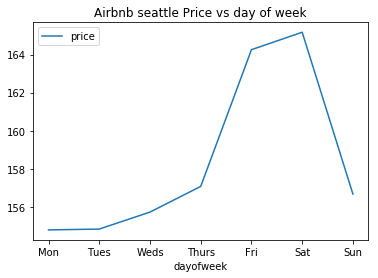

In [9]:
calendar['dayofweek'] = calendar.date.dt.weekday_name
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week = price_week.groupby(['dayofweek']).mean().reindex(cats)
print(price_week.iloc[0:10,].round(2))
#price_week.drop(['listing_id', 'minimum_nights','maximum_nights'] ,axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.title('Airbnb '+ city + ' Price vs day of week')
plt.xticks(ticks, labels);

#### Q: Is there a clear weekly pattern on the price?
A：Yes. Weekend Rate is generally <10% higher than that in the weekdays. 

#### Q: How does the average availability of Airbnb homes vary over time in each city?
Find out daily average availability for the time period. Convert available column to 0 if available and 1 if not.

In [10]:
calendar.available.value_counts()
#f (false) means not available, t(true) means available.

f    2068096
t    1241359
Name: available, dtype: int64

In [11]:
# calendar['maximum_nights'].value_counts()

In [12]:
calendar.date.min(), calendar.date.max()

(Timestamp('2019-08-18 00:00:00'), Timestamp('2020-08-25 00:00:00'))

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


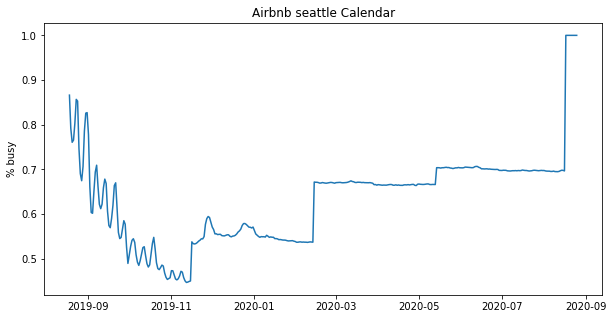

In [13]:
# Find out daily average availability for the time period. Convert available column to 0 if available and 1 if not.
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb '+ city + ' Calendar')
plt.ylabel('% busy')
plt.show();

#### Q: How does the average availability of Airbnb homes vary over time in each city?
Seattle has the highest occupancy rate in Sept. 

In [14]:
#calendar.drop_duplicates()
#calendar.drop_duplicates(keep='first', inplace=True)
#calendar.info()

### Prepare Listing Data Set to Answer Question 2

In [121]:
#checking for missing values in the listing data frame
def identify_null_col(dataframe):
    """Identify columns that have missing data in the dataframe
    Args:
        dataframe: input dataframe to identify missing data
    Returns:
        dataframe: dataframe of column names as index, # missing records, % missing records
    """
    null_col = dataframe.columns[dataframe.isna().sum()>0]
    col_null_val = dataframe[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (dataframe[null_col].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    nulls_df = pd.DataFrame(col_null_val,columns=['#Nulls'])
    nulls_df['%Nulls']=per_null_val
    print('Number of columns with missing data:',nulls_df.shape[0])
    return nulls_df
identify_null_col(listing)

Number of columns with missing data: 40


,#Nulls,%Nulls
thumbnail_url,9067,100.000000
medium_url,9067,100.000000
xl_picture_url,9067,100.000000
host_acceptance_rate,9067,100.000000
square_feet,8653,95.433991
monthly_price,8254,91.033418
weekly_price,8011,88.353369
license,7783,85.838756
notes,3612,39.836771
access,2984,32.910555


In [122]:
#listing.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

In [123]:
listing.review_scores_rating.describe()

count    7787.000000
mean       95.205342
std         6.720701
min        20.000000
25%        94.000000
50%        97.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


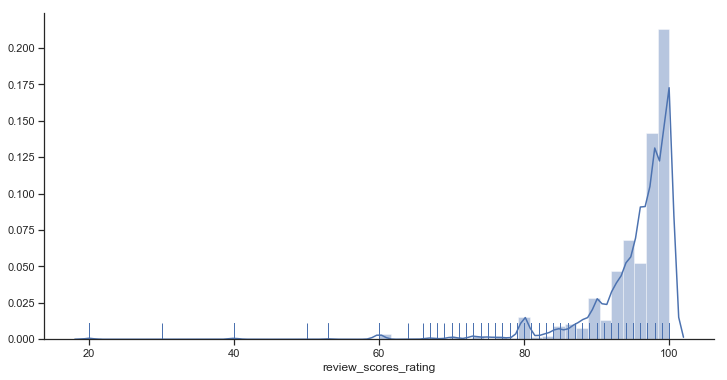

In [124]:
#understand distribution of review rating
plt.figure(figsize=(12,6))
sns.distplot(listing.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.show();

In [125]:
#convert price info to float type
listing['price'] = listing['price'].str.replace(',', '')
listing['price'] = listing['price'].str.replace('$', '')
listing['price'] = listing['price'].astype(float)
listing['price'].describe()

count    9067.000000
mean      170.404434
std       191.800017
min         0.000000
25%        82.000000
50%       120.000000
75%       191.000000
max      5400.000000
Name: price, dtype: float64

In [126]:
listing.iloc[np.argmax(listing['price'])]

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


id                                                                                       27372338
listing_url                                                 https://www.airbnb.com/rooms/27372338
scrape_id                                                                          20190818165751
last_scraped                                                                           2019-08-18
name                                               Convenient location--Special for Jan Long term
summary                                         This impressive home has wonderful light and i...
space                                           Elegantly furnished living and dining area.  A...
description                                     This impressive home has wonderful light and i...
experiences_offered                                                                          none
neighborhood_overview                           Madison Valley is an up and coming Seattle nei...
notes               

In [127]:
listing.iloc[np.argmax(listing['price'])]['neighbourhood_cleansed']

'Harrison/Denny-Blaine'

cutoff is 745.80


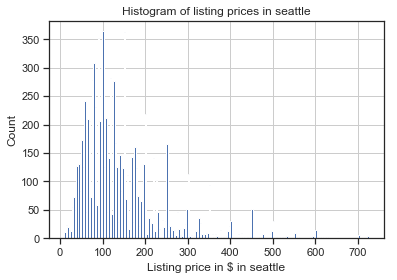

In [128]:
outlier = listing.price.mean()+ 3*listing.price.std()
print ('cutoff is {:.2f}'.format(outlier))
#print ('cutoff is %.2f %.4f' % (outlier, outlier))

listing.loc[(listing.price <= outlier)  & (listing.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $ in ' + city)
plt.title('Histogram of listing prices in ' + city);

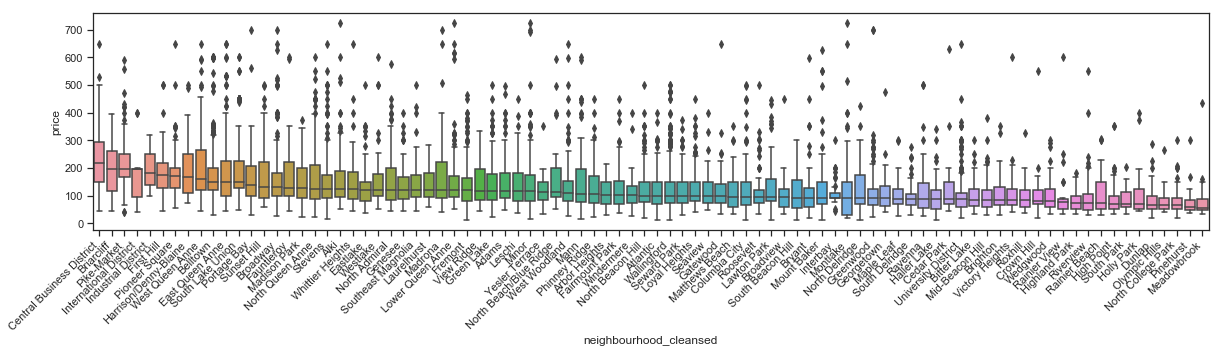

In [129]:
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('neighbourhood_cleansed')['price'].median()\
            .sort_values(ascending=False).index
plt.figure(figsize = (20,4))
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [130]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('neighbourhood_cleansed')['price']\
        .describe().sort_values('count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Broadway,572.0,149.293706,85.687604,28.0,98.00,130.0,180.00,700.0
Belltown,477.0,174.218029,90.339710,30.0,120.00,150.0,200.00,600.0
First Hill,340.0,179.738235,68.535668,45.0,128.00,175.0,219.00,500.0
Wallingford,329.0,133.401216,94.319208,10.0,75.00,100.0,150.00,500.0
Minor,299.0,142.210702,97.230918,15.0,80.00,115.0,175.00,725.0
Fremont,295.0,135.016949,75.035749,10.0,80.00,119.0,165.00,464.0
University District,274.0,99.970803,72.670609,20.0,60.00,86.0,110.00,650.0
Central Business District,244.0,237.602459,112.529291,46.0,150.00,219.0,292.25,650.0
Stevens,238.0,144.537815,99.778556,15.0,90.00,125.0,175.00,650.0


In [136]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('neighbourhood_cleansed')['property_type'].value_counts()

neighbourhood_cleansed     property_type     
Adams                      Townhouse              42
                           Apartment              35
                           House                  28
                           Condominium             9
                           Guest suite             7
                           Guesthouse              4
                           Loft                    3
                           Boat                    1
                           Boutique hotel          1
                           Bungalow                1
                           Cottage                 1
                           Serviced apartment      1
Alki                       House                  37
                           Guest suite            19
                           Apartment              15
                           Townhouse              12
                           Condominium             5
                           Cottage                 5


In [163]:
listing.loc[(listing.price <= outlier) & (listing.price > 0) & (listing.property_type.isin(['House','Apartment'])) ]\
                .groupby(['neighbourhood_cleansed', 'property_type']) \
                .count()['price'][lambda v: v>50]

neighbourhood_cleansed     property_type
Belltown                   Apartment        308
Broadway                   Apartment        380
                           House             76
Central Business District  Apartment        153
Columbia City              House             70
First Hill                 Apartment        270
Fremont                    Apartment         93
                           House            108
Green Lake                 House             59
Greenwood                  House            109
International District     Apartment         71
Lower Queen Anne           Apartment        125
Mann                       House             70
Minor                      Apartment         89
                           House             97
Montlake                   House             58
Mount Baker                House             53
North Admiral              House             54
North Beacon Hill          House             76
North Queen Anne           House             70

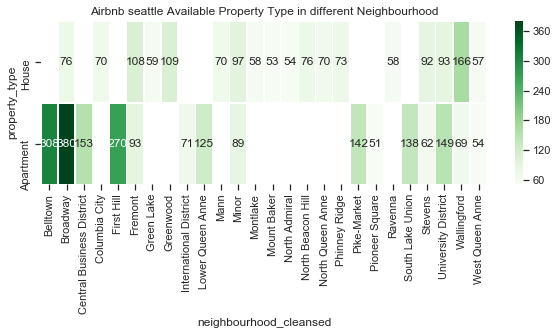

In [174]:
plt.figure(figsize=(10,3))
sns.heatmap(listing.loc[(listing.price <= outlier) & (listing.price > 0) & (listing.property_type.isin(['House','Apartment'])) ]\
                .groupby(['property_type','neighbourhood_cleansed'])\
                .count()['price'][lambda v: v>50]\
                .reset_index()\
                .pivot('property_type','neighbourhood_cleansed', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)
plt.title("Airbnb " + city + ' Available Property Type in different Neighbourhood')
plt.show();

### Q: Which neighborhood is the most expensive and which neighbourhood has most units? 
A: Central Business District has the highest median price, and Broadway District has 572 units listing. 

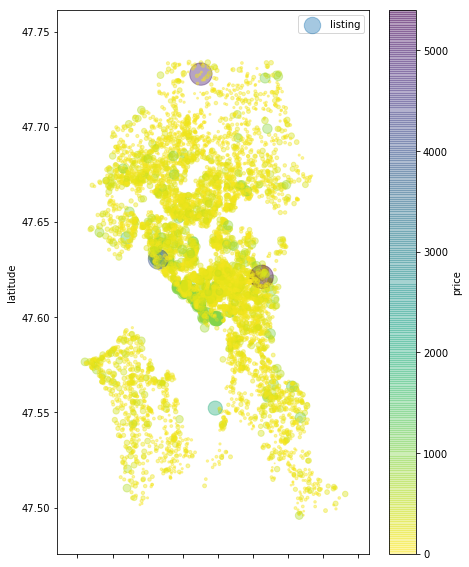

In [57]:
# Price based on geographical data
listing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4
             ,s=listing['price']/10
             , label = 'listing'
            , c = 'price', figsize =(7,10)
            , cmap = plt.get_cmap("viridis_r")
            , colorbar=True);

plt.legend();

In [58]:
#inspect and understand more of listing data
unique_host = listing['host_id'].unique()
'Number of unique hosts in listing dataset:', len(unique_host)
# %Superhosts in the dataset
listing['host_is_superhost'].value_counts()/listing.shape[0]*100

f    57.505239
t    42.494761
Name: host_is_superhost, dtype: float64

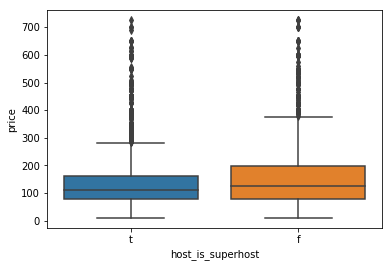

In [59]:
sns.boxplot(y='price', x='host_is_superhost', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)])
plt.show();

In [133]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('host_is_superhost')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,,,,,,,,
0,4974.0,150.551066,99.878433,10.0,80.0,125.0,199.0,725.0
1,3838.0,138.661282,94.695790,10.0,80.0,110.0,161.0,725.0


##### for Seattle, being a superhost does not seem to grant a better price for the house.. a little bit counter-intuititve... 

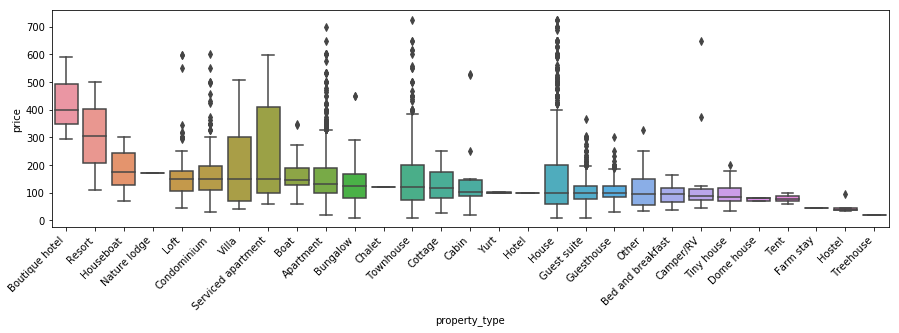

In [60]:
plt.figure(figsize = (15,4))
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('property_type')['price'].median()\
                    .sort_values(ascending=False).index
sns.boxplot(y='price', x='property_type', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [83]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].property_type.value_counts().sort_values(ascending = False)

listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('property_type')['price'].describe().sort_values('count',ascending = False)
#listing.loc[(listing.price <= outlier) & (listing.price > 0)]['price'].median()

120.0

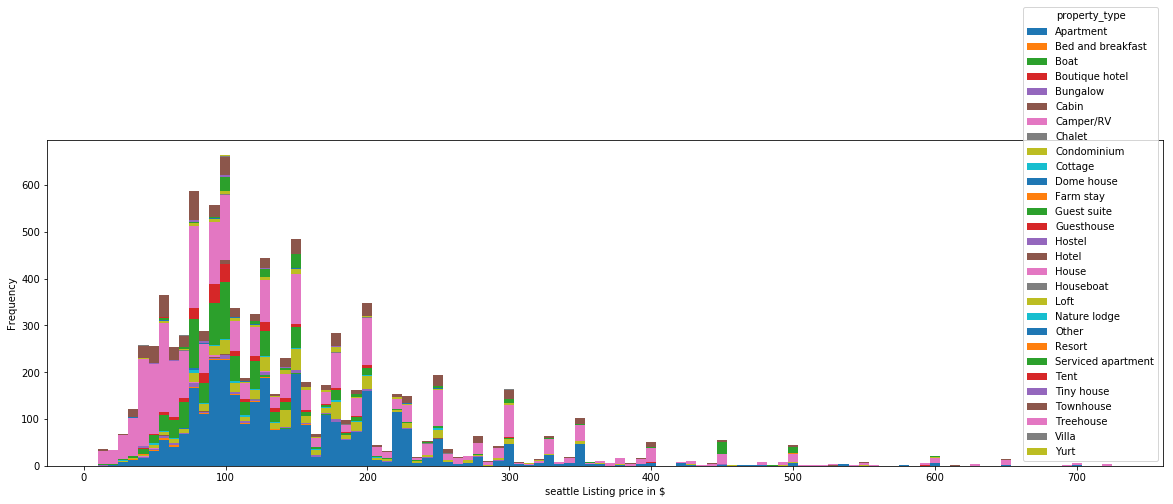

In [69]:
listing.loc[(listing.price <= outlier) & (listing.price > 0)].pivot(columns = 'property_type', values = 'price')\
        .plot.hist(stacked = True, bins=100, figsize = (20,6))

plt.xlabel(city + ' Listing price in $'); 

#### Q: Which property type is most common? 
A: Apartment & House are both quite common. At lower price range, there are more selection of houses; 
    Above $120 median price, there are more available apartment. 
In addition, based on the boxplot data visualization, there seems to be a difference in price for different property type. 
This factor should be considered in price model prediction. 

#### Other Data Exploration for Listing

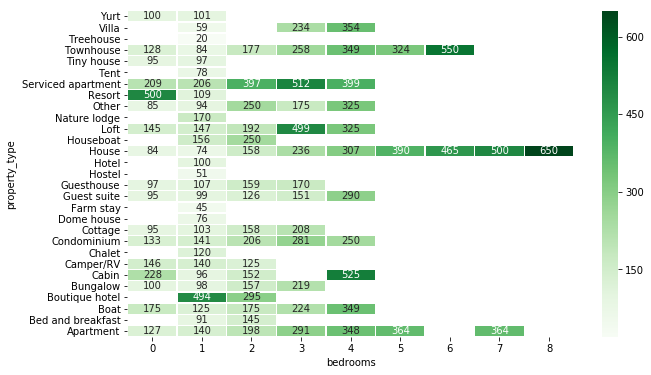

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(listing.loc[(listing.price <= outlier) & (listing.price > 0)]\
                .groupby(['property_type', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('property_type', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)
plt.show();

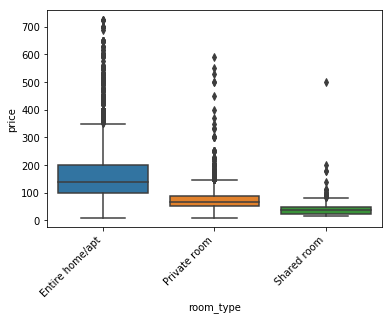

In [85]:
sort_price = listing.loc[(listing.price <= outlier) & (listing.price > 0)].groupby('room_type')['price'].median()\
                    .sort_values(ascending=False).index
sns.boxplot(y='price', x='room_type', data=listing.loc[(listing.price <= outlier) & (listing.price > 0)], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show(); 

### Modelling Listing Price 
#### Data preprocessing and feature engineering

In [86]:
#### Handle categorical and missing data for Listing.csv

In [90]:
'''listing.amenities = listing.amenities.str.replace("[{}]", "").str.replace('"', "")
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listing['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)'''

'listing.amenities = listing.amenities.str.replace("[{}]", "").str.replace(\'"\', "")\nfrom sklearn.feature_extraction.text import CountVectorizer\ncount_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(\',\'))\namenities = count_vectorizer.fit_transform(listing[\'amenities\'])\ndf_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())\ndf_amenities = df_amenities.drop(\'\',1)'

In [86]:
# convert binary column into interger format
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']

for c in columns:
    listing[c] = listing[c].replace('f',0,regex=True)
    listing[c] = listing[c].replace('t',1,regex=True)

In [87]:
# fill NA
listing['security_deposit'] = listing['security_deposit'].fillna(value=0)
listing['security_deposit'] = listing['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listing['cleaning_fee'] = listing['cleaning_fee'].fillna(value=0)
listing['cleaning_fee'] = listing['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)


In [88]:
#listing['zipcode'] = listing['zipcode'].str.replace('98104-4417','98104').astype(float)

In [89]:
listing_new = listing[['host_is_superhost', 'host_total_listings_count', 'bedrooms', 'number_of_reviews','review_scores_rating',
                       'neighbourhood_cleansed','room_type','property_type','square_feet','accommodates','price']]

In [90]:
sorted(listing.columns.tolist())
sorted(listing_new.columns.tolist())

['accommodates',
 'bedrooms',
 'host_is_superhost',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'review_scores_rating',
 'room_type',
 'square_feet']

In [91]:
corr = listing_new.loc[(listing_new.price <= outlier) & (listing_new.price > 0)].dropna().corr()

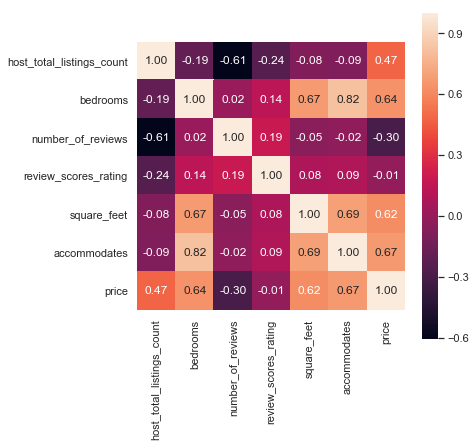

In [47]:
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f')
plt.show();

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


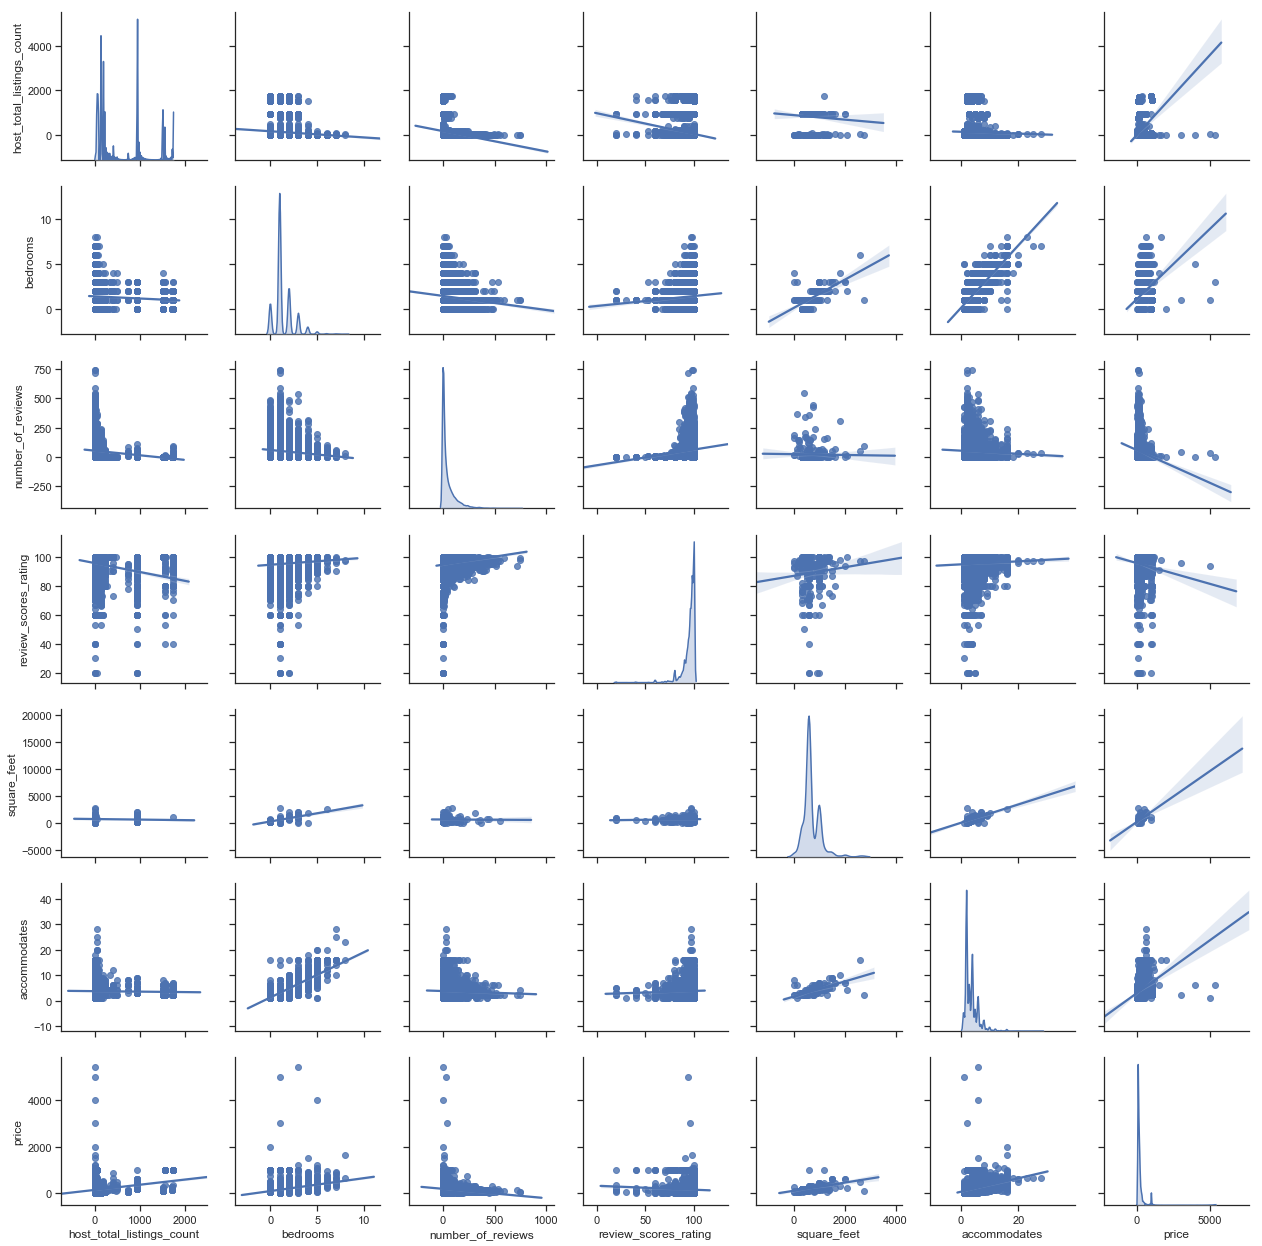

In [48]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(listing_new,diag_kind='kde',palette="husl", kind='reg')

In [92]:
for col in listing_new.columns[listing_new.isnull().any()]:
    print('Filling NA for column {}'.format(col))
    listing_new[col] = listing_new[col].fillna(listing_new[col].median())

Filling NA for column review_scores_rating
Filling NA for column square_feet


C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
listing_new = pd.get_dummies(listing_new, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)

In [94]:
#listing_new = pd.concat([listing_new, df_amenities], axis=1, join='inner')

In [95]:
sorted(listing_new.columns.tolist())

['accommodates',
 'bedrooms',
 'host_is_superhost',
 'host_total_listings_count',
 'neighbourhood_cleansed_Alki',
 'neighbourhood_cleansed_Arbor Heights',
 'neighbourhood_cleansed_Atlantic',
 'neighbourhood_cleansed_Belltown',
 'neighbourhood_cleansed_Bitter Lake',
 'neighbourhood_cleansed_Briarcliff',
 'neighbourhood_cleansed_Brighton',
 'neighbourhood_cleansed_Broadview',
 'neighbourhood_cleansed_Broadway',
 'neighbourhood_cleansed_Bryant',
 'neighbourhood_cleansed_Cedar Park',
 'neighbourhood_cleansed_Central Business District',
 'neighbourhood_cleansed_Columbia City',
 'neighbourhood_cleansed_Crown Hill',
 'neighbourhood_cleansed_Dunlap',
 'neighbourhood_cleansed_East Queen Anne',
 'neighbourhood_cleansed_Eastlake',
 'neighbourhood_cleansed_Fairmount Park',
 'neighbourhood_cleansed_Fauntleroy',
 'neighbourhood_cleansed_First Hill',
 'neighbourhood_cleansed_Fremont',
 'neighbourhood_cleansed_Gatewood',
 'neighbourhood_cleansed_Genesee',
 'neighbourhood_cleansed_Georgetown',
 'neighb

In [96]:
c = listing_new.dtypes
c[lambda x: x=='object']

Series([], dtype: object)

In [97]:
'''for cat_feature in ['property_type', 'room_type','neighbourhood_cleansed']:
        listing_new = pd.concat([listing_new, pd.get_dummies(listing[cat_feature], drop_first=True)], axis=1)
listing_new = pd.concat([listing_new, pd.get_dummies(listing, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)], axis=1)

listing_new.drop(['property_type', 'room_type','neighbourhood_cleansed'] ,axis=1, inplace=True)'''

"for cat_feature in ['property_type', 'room_type','neighbourhood_cleansed']:\n        listing_new = pd.concat([listing_new, pd.get_dummies(listing[cat_feature], drop_first=True)], axis=1)\nlisting_new = pd.concat([listing_new, pd.get_dummies(listing, columns = ['property_type', 'room_type','neighbourhood_cleansed'], drop_first=True)], axis=1)\n\nlisting_new.drop(['property_type', 'room_type','neighbourhood_cleansed'] ,axis=1, inplace=True)"

##random forest modelling

In [98]:
y = listing_new['price']
x = listing_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1, max_depth=None)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_test= (mean_squared_error(y_test,y_test_pred))**(1/2)
rmse_train= (mean_squared_error(y_train,y_train_pred))**(1/2)

print('RMSE train: %.3f' % rmse_train)
print('R^2 train: %.3f' % (r2_score(y_train, y_train_pred)))

print('RMSE test: %.3f' % rmse_test)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE train: 36.818
R^2 train: 0.954
RMSE test: 192.942
R^2 test: 0.374


In [99]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

# Initialize the classifier
rf_trial = RandomForestRegressor(criterion = 'mse', random_state = 3)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"n_estimators":[100,200,300], 
             "max_depth":[3,4,5]
                }

# erform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
skfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_obj = GridSearchCV(rf_trial, parameters, scoring='neg_mean_squared_error', cv=skfold, n_jobs=-1)

# it the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rf_trial = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions = best_rf_trial.predict(X_test)

print("\nOptimized Model\n------")
print("Final MSE on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))
print("Final R2 on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\liapr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Optimized Model
------
Final MSE on the testing data: 38160.9905
Final R2 on the testing data: 0.3582


In [100]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys()) 

In [101]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
1,host_total_listings_count,0.460542
6,accommodates,0.092805
2,bedrooms,0.092548
3,number_of_reviews,0.070457
4,review_scores_rating,0.041185
71,neighbourhood_cleansed_International District,0.039959
36,room_type_Private room,0.024795
0,host_is_superhost,0.022003
15,property_type_Condominium,0.019396
19,property_type_Guest suite,0.011939
